# Literature Search Crawl Report

Generate various stats validations from the artifacts of the literature search

In [1]:
import os
import re
import requests
import json
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
    
os.chdir(os.path.expanduser("/home/jovyan/data/pubmunch/crawl/"))

## Download

In [2]:
with open("download/pmids.txt") as f:
    pmids = set(f.read().splitlines())
print("{} PMIDs attempted".format(len(pmids)))

189 PMIDs attempted


In [3]:
download = pd.read_csv("download/docStatus.tab",
                       sep="\t", header=None, index_col=False, dtype=str,
                       names=["pmid", "status", "msg", "crawler", "journal", "year", "numFiles", "detail"])

print("{} ({}%) succeeded\n {} ({}%) failed\n".format(
    download[download.status == "OK"].shape[0], 
    round(100 * download[download.status == "OK"].shape[0] / len(pmids)),
    download[download.status != "OK"].shape[0], 
    round(100 * download[download.status != "OK"].shape[0] / len(pmids))))
print(download.status.value_counts())

159 (84%) succeeded
 30 (16%) failed

OK                     159
invalidPdf              20
HighwirePdfNotValid      4
noCrawlerSuccess         3
httpError                2
noLicense                1
Name: status, dtype: int64


## Find

In [4]:
variants = pd.read_csv("variants-normalized.tsv",
                       sep="\t", header=0, encoding="utf-8",
                       usecols=["norm_g_hgvs", "pyhgvs_Genomic_Coordinate_38", "pyhgvs_cDNA", "Synonyms"])

print("{} variants in BRCA Exchange".format(variants.shape[0]))

mentions = pd.read_csv("mutations-trimmed.tsv",
                       sep="\t", header=0, encoding="utf-8", dtype="str")
print("{} mentions found".format(mentions.shape[0]))


matches = pd.read_csv("mentions-matched.tsv", sep="\t", header=0, encoding="utf-8", dtype=str)
print("{} matches found".format(matches.shape[0]))

21702 variants in BRCA Exchange
6186 mentions found
16640 matches found


In [5]:
with open("literature.json") as f:
    lit = json.loads(f.read())
print("{} Papers and {} Variants exported".format(len(lit["papers"]), len(lit["variants"])))

149 Papers and 5174 Variants exported


In [6]:
print("Papers that didn't yield any variants:")
set(pmids) - set(lit["papers"].keys())

Papers that didn't yield any variants:


{'10406662',
 '10506595',
 '10667592',
 '11385711',
 '11877378',
 '12552570',
 '12601471',
 '12606139',
 '12815598',
 '12955716',
 '12955719',
 '15300854',
 '15533909',
 '15829246',
 '16211554',
 '16528612',
 '16619214',
 '16786532',
 '16969499',
 '17279547',
 '17657584',
 '18375895',
 '18493658',
 '18680205',
 '18693280',
 '19070627',
 '19150617',
 '19287957',
 '19393826',
 '20020529',
 '20054658',
 '20513136',
 '20875879',
 '22430266',
 '28122244',
 '7545954',
 '7939630',
 '9333265',
 '9523200',
 '9805131'}

In [7]:
# print("Max mentions for a single variant: {} {}".format(
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38"]).size().idxmax(),
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38"]).size().max()))

# print("Max mentions for a single paper from one variant: {} {}".format(
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38", "pmid"]).size().idxmax(),
#     exploded.groupby(["pyhgvs_Genomic_Coordinate_38", "pmid"]).size().max()))

# print("Paper referenced from the most variants: {} {}".format(
#     exploded.groupby(["pmid"]).size().idxmax(),
#     exploded.groupby(["pmid"]).size().max()))

## Founder Mutations

Make sure the variant matches to several founder mutation articles as reported [here](https://github.com/BRCAChallenge/pubMunch-BRCA/issues/10) are present.

In [8]:
# Make sure all the articles were in the crawl
assert set([
    '11352856','12473589','14576434','15994883','16397213','18158280','20215531',
    '20608970','21598239','21987798','22430266','25192939','28122244','9042909','9145676']).issubset(pmids)

In [9]:
# BRCA1 185delAG: https://brcaexchange.org/variant/183889
# chr17:g.43124027:ACT>A
text = """
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Chodick et al. 2008 à https://www.ncbi.nlm.nih.gov/pubmed/18158280 (in article abstract)
Elstrodt et al. 2006 à https://www.ncbi.nlm.nih.gov/pubmed/16397213 (in article abstract)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article abstract)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Konishi et al. 2011 à https://www.ncbi.nlm.nih.gov/pubmed/21987798 (in abstract)
Linger and Kruk 2010 à https://www.ncbi.nlm.nih.gov/pubmed/20608970 (in article)
Satagopan et al. 2001 à https://www.ncbi.nlm.nih.gov/pubmed/11352856 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Stadler et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/21598239 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)

Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/111111 Spikein :-)
"""
print(set(re.findall(r"\/(\d+)", text)).difference(set(lit["variants"]["chr17:g.43124027:ACT>A"].keys())))
print("Not Crawled:", set(re.findall(r"\/(\d+)", text)) - set(pmids))

# **BRCA1 5382insC: https://brcaexchange.org/variant/180141**
# chr17:g.43057062:T>TG
text = """
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Mgbemena et al. 2017 à https://www.ncbi.nlm.nih.gov/pubmed/28122244 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)

Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/111111 Spikein :-)
"""
print(set(re.findall(r"\/(\d+)", text)).difference(set(lit["variants"]["chr17:g.43057062:T>TG"].keys())))
print("Not Crawled:", set(re.findall(r"\/(\d+)", text)) - set(pmids))

# **BRCA2 6174delT: https://brcaexchange.org/variant/177049**
# chr13:g.32340526:AT>A
text = """
Abeliovich et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9042909 (in article title)
Antoniou et al. 2005 à https://www.ncbi.nlm.nih.gov/pubmed/15994883 (in article title)
Chodick et al. 2008 à https://www.ncbi.nlm.nih.gov/pubmed/18158280 (in article abstract)
Finkelman et al. 2012 à https://www.ncbi.nlm.nih.gov/pubmed/22430266 (in article abstract)
Gabai-Kapara et al. 2014 à https://www.ncbi.nlm.nih.gov/pubmed/25192939 (in article introduction and methods)
Gallagher et al. 2010 à https://www.ncbi.nlm.nih.gov/pubmed/20215531 (in methods)
King et al. 2003 à https://www.ncbi.nlm.nih.gov/pubmed/14576434 (in article)
Satagopan et al. 2001 à https://www.ncbi.nlm.nih.gov/pubmed/11352856 (in abstract)
Satagopan et al. 2002 à https://www.ncbi.nlm.nih.gov/pubmed/12473589 (in abstract)
Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/9145676 (in abstract)

Struewing et al. 1997 à https://www.ncbi.nlm.nih.gov/pubmed/111111 Spikein :-)
"""
print(set(re.findall(r"\/(\d+)", text)).difference(set(lit["variants"]["chr13:g.32340526:AT>A"].keys())))
print("Not Crawled:", set(re.findall(r"\/(\d+)", text)) - set(pmids))

{'22430266', '111111'}
Not Crawled: {'111111'}
{'22430266', '28122244', '111111'}
Not Crawled: {'111111'}
{'22430266', '111111'}
Not Crawled: {'111111'}


## LOVD

In [10]:
lovd = pd.read_table(
    "https://raw.githubusercontent.com/BRCAChallenge/pubMunch-BRCA/master/tests/lovd-normalized.tsv", dtype=str)
print("{} pmids and {} variants in normalized LOVD truth set".format(
    len(set(lovd.pmid.values)),
    len(set(lovd.pyhgvs_Genomic_Coordinate_38.values))))
lovd.head()

175 pmids and 1044 variants in normalized LOVD truth set


,pmid,norm_c_hgvs,norm_g_hgvs,pyhgvs_Genomic_Coordinate_38
0,24667779,NM_007294.3:c.-19-22_-19-21dup,NC_000017.11:g.43124146_43124147dup,chr17:g.43124146_43124147:dup
1,10459348,NM_007294.3:c.-19-10T>C,NC_000017.11:g.43124125A>G,chr17:g.43124125:A>G
2,24667779,NM_007294.3:c.-19-10T>C,NC_000017.11:g.43124125A>G,chr17:g.43124125:A>G
3,16403807,NM_007294.3:c.-3G>C,NC_000017.11:g.43124099C>G,chr17:g.43124099:C>G
4,19393826,NM_007294.3:c.1_134del,NC_000017.11:g.43115728_43124098del,chr17:g.43115728_43124098:del


In [11]:
print("Missing from list of PMIDs to download:")
print(", ".join([p for p in set(lovd.pmid.values) if p not in pmids]))

print("\nFailed to download:")
print(", ".join(["{} ({})".format(p, download[download.pmid == p].status.values[0]) 
                   for p in set(lovd.pmid.values) if 
                   download[(download.pmid == p) & (download.status != "OK")].shape[0]]))

Missing from list of PMIDs to download:
09333265, 2010, 08531967, 08751436, 09523200, 07545954, 09497265, 09805131, 09971877, 08942979, 09126734, 07939630, 08896551, 09585599

Failed to download:
15533909 (HighwirePdfNotValid), 11385711 (invalidPdf), 12552570 (invalidPdf), 17657584 (invalidPdf), 20054658 (invalidPdf), 12601471 (httpError), 12815598 (invalidPdf), 10406662 (invalidPdf), 16969499 (noCrawlerSuccess), 17279547 (invalidPdf), 10506595 (HighwirePdfNotValid), 16619214 (invalidPdf), 20513136 (invalidPdf), 18493658 (noCrawlerSuccess), 15300854 (invalidPdf), 18375895 (HighwirePdfNotValid), 19287957 (noCrawlerSuccess), 16528612 (invalidPdf), 18693280 (invalidPdf), 20020529 (invalidPdf), 16211554 (invalidPdf), 18680205 (invalidPdf), 12955719 (invalidPdf), 16786532 (invalidPdf), 12955716 (invalidPdf)


In [12]:
lit_pmids = set([pmid for variant, mentions in lit["variants"].items() for pmid in mentions.keys()])

common_pmids = list(lit_pmids.intersection(set(lovd.pmid.values)))
print("{} common pmids between LOVD and this crawl".format(len(common_pmids)))

128 common pmids between LOVD and this crawl


In [13]:
# Invert the literature.json exported to BRCA Exchange to create a variants by pmid from literature
import itertools

lit_pmid_variant_tuple = [(pmid, variant) 
                          for variant, mention in lit["variants"].items() 
                          for pmid in list(mention.keys())]

lit_variants_by_pmid = {pmid: [v[1] 
                        for v in variants]
                        for pmid, variants in itertools.groupby(sorted(lit_pmid_variant_tuple), lambda x: x[0])}

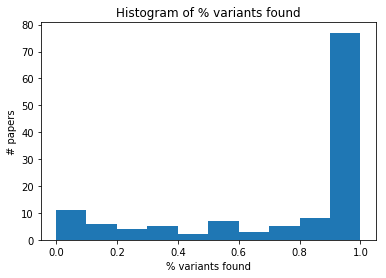

In [14]:
# Compute per paper the % of LOVD variants we found and exported in literature.json
pcts = {
    p: len(set(lit_variants_by_pmid[p]).intersection(
        set(lovd[lovd.pmid == p].pyhgvs_Genomic_Coordinate_38.values))) / len(
        set(lovd[lovd.pmid == p].pyhgvs_Genomic_Coordinate_38.values)) 
    for p in common_pmids}

lovd_stats = pd.DataFrame.from_dict(pcts, orient="index", columns=["pct"]).rename_axis("pmid")

plt.hist(lovd_stats.pct)
plt.title("Histogram of % variants found")
plt.xlabel("% variants found")
plt.ylabel("# papers")
plt.show()

## Compare Current LOVD

In [15]:
with open("/home/jovyan/public_html/literature-2018-11-14.json") as f:
    lit = json.loads(f.read())
print("{} Papers and {} Variants exported".format(len(lit["papers"]), len(lit["variants"])))


# Invert the literature.json exported to BRCA Exchange to create a variants by pmid from literature
import itertools

cur_lit_pmid_variant_tuple = [(pmid, variant) 
                          for variant, mention in lit["variants"].items() 
                          for pmid in list(mention.keys())]

cur_lit_variants_by_pmid = {pmid: [v[1] 
                        for v in variants]
                        for pmid, variants in itertools.groupby(sorted(cur_lit_pmid_variant_tuple), lambda x: x[0])}

2227 Papers and 3754 Variants exported


In [16]:
def confusion_matrix(lit_variants_by_pmid):
    TP, FP, FN, TN = 0, 0, 0, 0

    # Only evaluate papers in lovd and crawled
    for pmid in set([p for p in lovd.pmid.values if p in lit_variants_by_pmid.keys()]):
        actual = set(lovd[lovd["pmid"] == pmid].pyhgvs_Genomic_Coordinate_38.values)
        predicted = set(lit_variants_by_pmid[pmid])

        TP += len(predicted.intersection(actual))
        FP += len(predicted - actual)
        FN += len(actual - predicted)
#         TN += len(set(predicted.union(actual))) - (TP + FP + FN)
        
    return TP, FP, FN, TN

TP, FP, FN, TN = confusion_matrix(cur_lit_variants_by_pmid)

print("Current Production Confusion Matrix:")
print("{}\t{}".format(TP, FP))
print("{}\t{}".format(FN, TN))

TP, FP, FN, TN = confusion_matrix(lit_variants_by_pmid)

print("New Confusion Matrix w/Synonym Match:")
print("{}\t{}".format(TP, FP))
print("{}\t{}".format(FN, TN))

Current Production Confusion Matrix:
1094	1237
675	0
New Confusion Matrix w/Synonym Match:
1160	7263
703	0


## Debug

In [17]:
os.environ['UTA_DB_URL']='postgresql://anonymous@rcurrie-uta:5432/uta/uta_20170117'
os.environ['HGVS_SEQREPO_DIR']='/home/jovyan/data/pubmunch/references/seqrepo/2018-10-03'

!pip install --user --quiet hgvs
import hgvs.parser
import hgvs.dataproviders.uta
import hgvs.assemblymapper

parser = hgvs.parser.Parser()
server = hgvs.dataproviders.uta.connect()
mapper = hgvs.assemblymapper.AssemblyMapper(server, assembly_name="GRCh38")

You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [39]:
pmid = "15994883"

download[download.pmid == pmid].head()

,pmid,status,msg,crawler,journal,year,numFiles,detail
47,15994883,OK,main.html contains html tag,highwire,Journal of medical genetics,2005,3,NaN


In [40]:
mentions[mentions.docId == pmid][["hgvsCoding", "texts"]].head()
# mentions[mentions.docId == pmid].iloc[2]

,hgvsCoding,texts
1021,NM_000059.3:c.6174T>None,6174delT|6174delT
1022,NaN,185delAG|185delAG
1023,NaN,5382insC| 5382insC
1025,NM_000059.3:c.6174T>None,6174delT|6174delT
1026,NaN,185delAG|185delAG


In [29]:
candidate = mentions[mentions.docId == pmid].iloc[0].hgvsCoding
print("hgvsCoding", candidate)
normalized = re.sub(r"(NM.*c\.\d*)([ATCGatcg]+)(>None)", r"\1del\2", candidate)
print("normalized", normalized)
parsed_hgvs = parser.parse_hgvs_variant(normalized)
print("parsed_hgvs", parsed_hgvs)
mapped = mapper.c_to_g(parsed_hgvs)
print("mapped", mapped)

hgvsCoding NM_000059.3:c.6174T>None
normalized NM_000059.3:c.6174delT
parsed_hgvs NM_000059.3:c.6174del
mapped NC_000013.11:g.32340529del


In [30]:
matches[matches.pmid == pmid]

,pyhgvs_Genomic_Coordinate_38,pmid,snippets,score
2872,chr17:g.43124027:ACT>A,15994883,rsity Library ## You are here * Home * A...,3
2873,chr17:g.43057062:T>TG,15994883,Section University Library ## You are here ...,3
2874,chr17:g.43057059:T>TG,15994883,Section University Library ## You are here ...,3
2875,chr17:g.43124027:ACT>A,15994883,on based studies of women with breast and ovar...,3
2876,chr17:g.43057062:T>TG,15994883,ies of women with breast and ovarian cancer.1 ...,3
2877,chr17:g.43057059:T>TG,15994883,ies of women with breast and ovarian cancer.1 ...,3
2878,chr13:g.32340526:AT>A,15994883,ou are here * Home * Archive * Volume 4...,2
2879,chr13:g.32340526:AT>A,15994883,east and ovarian cancer.1 King et al2 estimate...,2


In [31]:
matches[matches.score == "1"]

,pyhgvs_Genomic_Coordinate_38,pmid,snippets,score


In [32]:
lit_variants_by_pmid[pmid]

['chr13:g.32340526:AT>A',
 'chr17:g.43057059:T>TG',
 'chr17:g.43057062:T>TG',
 'chr17:g.43124027:ACT>A']

In [36]:
variants[variants.pyhgvs_cDNA.str.contains("NM_000059.3:c.6174del")]

,norm_g_hgvs,Synonyms,pyhgvs_Genomic_Coordinate_38,pyhgvs_cDNA
5990,NC_000013.11:g.32340529del,"NC_000013.11.g.32340529delT,LRG_293t1.c.6174de...",chr13:g.32340526:AT>A,NM_000059.3:c.6174delT
